<a href="https://colab.research.google.com/github/yyic1203/Tesis/blob/main/H2HFGUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# GUP Hartree–Fock (H2): α^2 one–electron correction by Gauss quadrature in prolate spheroidal coords
# Author: ChatGPT (GPT-5 Thinking)
#
# What this script does
# ---------------------
# Computes the α^2 correction to the one–electron Hamiltonian matrix elements
#    Δh^{(2)}_{μν} = -(ħ^2/2m) α^2 ⟨φ_μ | Σ_i (x_i^2 ∂_i^2 + x_i ∂_i) | φ_ν⟩
# for H2 with 1s–1s STO basis, using Gauss–Laguerre in μ (with μ=1+u/(ζR))
# and Gauss–Legendre in ν and φ. Atomic units are used by default (ħ=1, m=1).
#
# Notes:
# - Centers are placed at z=±R/2.
# - We assume ζ_A = ζ_B = ζ (homonuclear H2).
# - The integral is done directly in (μ,ν,φ) using the prolate formulas:
#     r_A = (R/2)(μ+ν), r_B = (R/2)(μ-ν)
#     x = (R/2)√[(μ^2-1)(1-ν^2)] cosφ, y = ... sinφ, z = (R/2) μ ν
#     dV  = (R^3/8)(μ^2-ν^2) dμ dν dφ
# - We evaluate χ_A χ_B analytically as N^2 e^{-ζ(r_A+r_B)} = N^2 e^{-ζR μ}
#   and factor e^{-ζR μ} = e^{-p} e^{-u} with u = p(μ-1), p=ζR, so Laguerre works.
# - For AA and BB, χ_A χ_A = N^2 e^{-2ζ r_A} = N^2 e^{-ζR(μ+ν)} and
#   χ_B χ_B = N^2 e^{-2ζ r_B} = N^2 e^{-ζR(μ-ν)}. The ν-dependent exponential is
#   handled inside the ν-loop (it does not affect Laguerre weights).
#
# You can adjust quadrature orders (n_u, n_nu, n_phi) at the bottom.


import numpy as np
from numpy.polynomial.legendre import leggauss as gauss_legendre
from numpy.polynomial.laguerre import laggauss as gauss_laguerre
from dataclasses import dataclass
from typing import Literal, Tuple


@dataclass
class Params:
    R: float = 1.4        # internuclear distance (bohr)
    zeta: float = 1.24    # Slater exponent for H 1s (STO-1G-ish)
    alpha: float = 3   # deformation parameter (units consistent with your model)
    use_atomic_units: bool = True  # if True: ħ^2/2m = 1/2


def sto_1s_norm(zeta: float) -> float:
    """Normalization for 1s STO: N = (ζ^3/π)^{1/2} (atomic units)."""
    return (zeta**3 / np.pi) ** 0.5


def prolate_to_cartesian(mu, nu, phi, R):
    """Return x,y,z arrays from (μ,ν,φ) for internuclear distance R."""
    # radial cylinder component
    rho = 0.5 * R * np.sqrt((mu**2 - 1.0) * (1.0 - nu**2))
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    z = 0.5 * R * mu * nu
    return x, y, z


def r_center(x, y, z, center: Literal["A", "B"], R: float):
    """Distance to center A (-R/2) or B (+R/2) along z-axis."""
    if center == "A":
        zc = -0.5 * R
    else:
        zc =  0.5 * R
    return np.sqrt(x**2 + y**2 + (z - zc)**2)


def S_local(x, y, z, center_ket: Literal["A","B"], R: float, zeta: float) -> np.ndarray:
    """
    Compute the local factor S(x,y,z) such that
      Σ_i [ x_i^2 ∂_i^2 χ_ket + x_i ∂_i χ_ket ] = χ_ket * S_local
    for ket centered at A or B.
    """
    # shift to ket center
    zc = -0.5 * R if center_ket == "A" else 0.5 * R
    ux = x          # x - Xc (Xc=0)
    uy = y
    uz = z - zc
    r = np.sqrt(ux**2 + uy**2 + uz**2)
    # Avoid divide-by-zero (point measure zero); clip r minimally
    eps = 1e-14
    r = np.maximum(r, eps)

    # precompute ratios
    rx = ux / r
    ry = uy / r
    rz = uz / r

    # First derivatives multipliers: ∂i χ = -ζ (ui/r) χ
    # Second derivative multipliers: ∂i^2 χ = [ ζ^2 (ui^2/r^2) - ζ(1/r - ui^2/r^3) ] χ
    # Build Σ_i [ x_i^2 * (...) + x_i * (...) ]
    # For i=x:
    term_x = (x**2) * (zeta**2 * rx**2 - zeta * (1.0/r - rx**2 / r)) + x * (-zeta * rx)
    # For i=y:
    term_y = (y**2) * (zeta**2 * ry**2 - zeta * (1.0/r - ry**2 / r)) + y * (-zeta * ry)
    # For i=z:
    term_z = (z**2) * (zeta**2 * rz**2 - zeta * (1.0/r - rz**2 / r)) + z * (-zeta * rz)

    return term_x + term_y + term_z


def product_exponential_factor(mu, nu, zeta, R, bra: Literal["A","B"], ket: Literal["A","B"]) -> Tuple[float, float]:
    """
    Returns (const_prefactor, nu_factor) such that
      χ_bra χ_ket = N^2 * const_prefactor * e^{-u} * nu_factor
    with u = p(μ-1), p=ζR, and:
      const_prefactor = exp(-p) (μ-dependent part extracted)
      nu_factor       = 1 (AB), exp(-ζR ν) (AA), exp(+ζR ν) (BB)
    """
    p = zeta * R
    const_prefactor = np.exp(-p)  # from e^{-ζR μ} = e^{-p} e^{-u}
    if bra == "A" and ket == "A":
        nu_factor = np.exp(-zeta * R * nu)
    elif bra == "B" and ket == "B":
        nu_factor = np.exp(+zeta * R * nu)
    else:  # AB or BA
        nu_factor = 1.0
    return const_prefactor, nu_factor


def one_electron_alpha2(
    params: Params,
    bra: Literal["A","B"],
    ket: Literal["A","B"],
    n_u: int = 40,
    n_nu: int = 60,
    n_phi: int = 16,
) -> Tuple[float, float]:
    """
    Compute I_core and Δh^{(2)}_{bra,ket}:
      I_core = ∫ χ_bra χ_ket S_local (R^3/8)(μ^2-ν^2) dμ dν dφ
      Δh^{(2)} = -(ħ^2/2m) α^2 * I_core
    using Gauss–Laguerre (μ) and Gauss–Legendre (ν, φ).
    Returns (I_core, Δh).
    """
    R, zeta, alpha = params.R, params.zeta, params.alpha
    # Constants
    N = sto_1s_norm(zeta)
    N2 = N * N
    p = zeta * R

    # Quadratures
    # u in [0,∞), with Laguerre weight e^{-u}
    u_nodes, u_w = gauss_laguerre(n_u)  # nodes u_k >= 0, weights for ∫ e^{-u} f(u) du
    # ν in [-1,1]
    nu_nodes, nu_w = gauss_legendre(n_nu)
    # φ in [0, 2π] via mapping φ = π(t+1) with t in [-1,1]
    t_phi, w_phi_leg = gauss_legendre(n_phi)
    phi_nodes = np.pi * (t_phi + 1.0)
    phi_w = np.pi * w_phi_leg  # dφ = π dt

    # Prefactors independent of nodes
    const_mu = (R**3 / 8.0) * (1.0 / p)  # dV and dμ = du/p
    # χ_bra χ_ket = N2 * e^{-u} * (exp(-p) * nu_factor)
    const_e_mu, _ = product_exponential_factor(1.0, 0.0, zeta, R, bra, ket)  # const part e^{-p}
    const_front = N2 * const_e_mu * const_mu

    # Prepare grids: broadcast u, ν, φ to 3D
    U, NU, PHI = np.meshgrid(u_nodes, nu_nodes, phi_nodes, indexing="ij")
    WU, WNU, WPHI = np.meshgrid(u_w, nu_w, phi_w, indexing="ij")

    MU = 1.0 + U / p  # μ = 1 + u/p
    # Cartesian coords for every grid point
    X, Y, Z = prolate_to_cartesian(MU, NU, PHI, R)

    # Jacobian factor (μ^2 - ν^2)
    jac = (MU**2 - NU**2)

    # Local S at ket center
    S_loc = S_local(X, Y, Z, center_ket=ket, R=R, zeta=zeta)

    # ν-dependent exponential factor
    # Need it pointwise; bra,ket fixed.
    _, nu_factor_scalar = product_exponential_factor(1.0, 0.0, zeta, R, bra, ket)
    if np.isscalar(nu_factor_scalar) and nu_factor_scalar == 1.0:
        NU_FACTOR = 1.0
    else:
        NU_FACTOR = np.exp( (zeta*R) * ( NU if (bra=="B" and ket=="B") else (-NU) ) )

    # Assemble integrand (without e^{-u}, because Laguerre weights already include e^{-u})
    integrand = S_loc * jac * NU_FACTOR

    # Sum with weights
    # weights: WU (Laguerre), WNU (Legendre), WPHI (Legendre-mapped)
    I_core = const_front * np.sum(integrand * WU * WNU * WPHI)

    # Kinetic prefactor -(ħ^2/2m) α^2
    if params.use_atomic_units:
        pref_kin = -0.5 * (alpha**2)
    else:
        # If not in a.u., set your own ħ and m here
        hbar = 1.0
        m = 1.0
        pref_kin = -(hbar**2 / (2.0*m)) * (alpha**2)

    Delta_h = pref_kin * I_core
    return float(I_core), float(Delta_h)


def demo():
    p = Params(R=1.4, zeta=1.24, alpha=3, use_atomic_units=True)

    print("=== GUP α^2 one–electron correction for H2 (1s–1s STO) ===")
    print(f"R = {p.R:.6f} bohr, ζ = {p.zeta:.6f}, α = {p.alpha:.3e}")
    print("Quadrature orders: n_u=40, n_nu=60, n_phi=16 (edit in code).")
    print()

    # Off-diagonal AB (and BA equal by symmetry)
    Iab, Dhab = one_electron_alpha2(p, bra="A", ket="B", n_u=40, n_nu=60, n_phi=16)
    print(f"I_core(AB)  = {Iab:.8e}  [a.u.]")
    print(f"Δh^(2)_(AB) = {Dhab:.8e}  [Hartree]")
    print()

    # Diagonals AA and BB (should be equal by symmetry for homonuclear case)
    Iaa, Dh_aa = one_electron_alpha2(p, bra="A", ket="A", n_u=40, n_nu=60, n_phi=16)
    Ibb, Dh_bb = one_electron_alpha2(p, bra="B", ket="B", n_u=40, n_nu=60, n_phi=16)
    print(f"I_core(AA)  = {Iaa:.8e}  [a.u.]")
    print(f"I_core(BB)  = {Ibb:.8e}  [a.u.]")
    print(f"Δh^(2)_(AA) = {Dh_aa:.8e}  [Hartree]")
    print(f"Δh^(2)_(BB) = {Dh_bb:.8e}  [Hartree]")
    print()

    print("Note: Δh = -(1/2) α^2 * I_core  (atomic units).")
    print("For production, increase (n_u, n_nu, n_phi) until values converge.")

demo()




=== GUP α^2 one–electron correction for H2 (1s–1s STO) ===
R = 1.400000 bohr, ζ = 1.240000, α = 3.000e+00
Quadrature orders: n_u=40, n_nu=60, n_phi=16 (edit in code).

I_core(AB)  = -1.95367664e-01  [a.u.]
Δh^(2)_(AB) = 8.79154489e-01  [Hartree]

I_core(AA)  = -1.95367664e-01  [a.u.]
I_core(BB)  = -1.95367664e-01  [a.u.]
Δh^(2)_(AA) = 8.79154489e-01  [Hartree]
Δh^(2)_(BB) = 8.79154489e-01  [Hartree]

Note: Δh = -(1/2) α^2 * I_core  (atomic units).
For production, increase (n_u, n_nu, n_phi) until values converge.


/tmp/ipython-input-2103618310.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  areas_abs[a] = float(np.trapz(diff, R_vals))  # Hartree·bohr


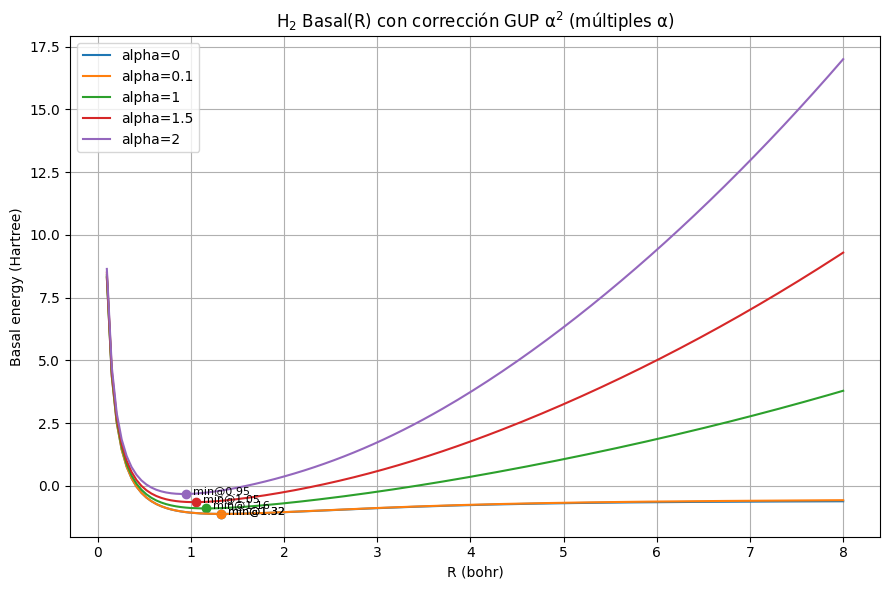

Áreas absolutas vs α=0 (Hartree·bohr):
  α= 0.1:  1.214365e-01
  α= 1.0:  1.214365e+01
  α= 1.5:  2.732322e+01
  α= 2.0:  4.857462e+01

Guardados: Basal_vs_R_multi_alpha.csv, Areas_vs_alpha0.csv


In [6]:
# -*- coding: utf-8 -*-
# H2 Basal(R) con corrección GUP α^2 (cuadraturas en prolatas) + áreas vs α=0

import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss as gauss_legendre
from numpy.polynomial.laguerre import laggauss as gauss_laguerre
import pandas as pd

# ------------------------------
# Utilidades geométricas y STO
# ------------------------------
def sto_1s_norm(zeta: float) -> float:
    """Normalización 1s STO (u.a.)."""
    return (zeta**3 / np.pi) ** 0.5

def prolate_to_cartesian(mu, nu, phi, R):
    """Transformación prolata → cartesiana para dos centros ±R/2 (eje z)."""
    rho = 0.5 * R * np.sqrt((mu**2 - 1.0) * (1.0 - nu**2))
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    z = 0.5 * R * mu * nu
    return x, y, z

def S_local(x, y, z, center_ket, R, zeta):
    """
    Construye el factor local S(x) tal que:
      Σ_i [ x_i^2 ∂_i^2 χ_ket + x_i ∂_i χ_ket ] = χ_ket * S_local
    usando derivadas analíticas de χ (STO 1s).
    """
    zc = -0.5 * R if center_ket == "A" else 0.5 * R
    ux = x
    uy = y
    uz = z - zc
    r = np.sqrt(ux**2 + uy**2 + uz**2)
    r = np.maximum(r, 1e-14)  # evitar división por cero

    rx = ux / r
    ry = uy / r
    rz = uz / r

    # ∂i χ = -ζ (ui/r) χ
    # ∂i^2 χ = [ ζ^2 (ui^2/r^2) - ζ (1/r - ui^2/r^3) ] χ
    term_x = (x**2) * (zeta**2 * rx**2 - zeta * (1.0/r - rx**2 / r)) + x * (-zeta * rx)
    term_y = (y**2) * (zeta**2 * ry**2 - zeta * (1.0/r - ry**2 / r)) + y * (-zeta * ry)
    term_z = (z**2) * (zeta**2 * rz**2 - zeta * (1.0/r - rz**2 / r)) + z * (-zeta * rz)
    return term_x + term_y + term_z

# ------------------------------
# Corrección de 1 electrón (α^2)
# ------------------------------
def one_electron_alpha2(R, zeta, alpha, bra, ket, n_u=24, n_nu=36, n_phi=12):
    """
    Calcula Δh^(2)_{bra,ket} = -(1/2) α^2 ∫ χ_bra χ_ket S_local (R^3/8)(μ^2-ν^2) dμ dν dφ
    vía Gauss–Laguerre (μ=1+u/(ζR)) y Gauss–Legendre (ν,φ).
    """
    p = zeta * R
    N2 = sto_1s_norm(zeta)**2

    # Cuadraturas
    u_nodes, u_w = gauss_laguerre(n_u)     # u ∈ [0,∞), peso e^{-u}
    nu_nodes, nu_w = gauss_legendre(n_nu)  # ν ∈ [-1,1]
    t_phi, w_phi_leg = gauss_legendre(n_phi)  # map a φ ∈ [0,2π]
    phi_nodes = np.pi * (t_phi + 1.0)
    phi_w = np.pi * w_phi_leg

    # Mallado 3D
    U, NU, PHI = np.meshgrid(u_nodes, nu_nodes, phi_nodes, indexing="ij")
    WU, WNU, WPHI = np.meshgrid(u_w, nu_w, phi_w, indexing="ij")

    MU = 1.0 + U / p
    X, Y, Z = prolate_to_cartesian(MU, NU, PHI, R)
    jac = (MU**2 - NU**2)
    S_loc = S_local(X, Y, Z, center_ket=ket, R=R, zeta=zeta)

    # Factor exponencial χ_bra χ_ket:
    # AB: e^{-ζR μ};   AA: e^{-ζR(μ+ν)};   BB: e^{-ζR(μ-ν)}
    if bra == "A" and ket == "A":
        expo = np.exp(-zeta*R*(MU + NU))
    elif bra == "B" and ket == "B":
        expo = np.exp(-zeta*R*(MU - NU))
    else:
        expo = np.exp(-zeta*R*MU)

    const_mu = (R**3 / 8.0) * (1.0 / p)   # dμ = du/p
    integrand = N2 * expo * S_loc * jac

    I_core = const_mu * np.sum(integrand * WU * WNU * WPHI)
    Delta_h = -0.5 * (alpha**2) * I_core  # u.a.
    return float(Delta_h)

# ------------------------------
# Energía Basal(R): tu formulación + Δh^(2)
# ------------------------------
def basal_energy(R, zeta=1.24, alpha=0.0, quad=(24,36,12)):
    """Devuelve (E_basal, meta) para un R dado."""
    n_u, n_nu, n_phi = quad

    # Correcciones GUP por cuadratura
    if alpha == 0.0:
        Dh_aa = 0.0
        Dhab  = 0.0
    else:
        Dh_aa = one_electron_alpha2(R, zeta, alpha, "A", "A", n_u, n_nu, n_phi)
        Dhab  = one_electron_alpha2(R, zeta, alpha, "A", "B", n_u, n_nu, n_phi)

    rho = zeta * abs(R)
    s12 = (1.0 + rho + rho**2/3.0) * np.exp(-rho)

    T11 = zeta**2 / 2.0
    T12 = (-zeta**2 / 2.0) * (s12 - 2.0*(1.0 + rho)*np.exp(-rho))

    V11A = -zeta
    V11B = (-zeta/rho) * (1.0 - (1.0 + rho)*np.exp(-2.0*rho))
    V12A = -zeta * (1.0 + rho) * np.exp(-rho)
    V12B = -zeta * (1.0 + rho) * np.exp(-rho)

    h11 = T11 + V11A + V11B + Dh_aa
    h12 = T12 + V12A + V12B + Dhab

    epsilong = (h11 + h12) / (1.0 + s12)

    # Términos de dos electrones (formas cerradas corregidas que me pasaste)
    A=(1.0 - rho + (rho**2)/3.0)*np.exp(rho)
    B=np.exp(-4.0*rho)*np.log(1.0 + 1.0/(4.0*rho))
    C=np.exp(-2.0*rho)*np.log(1.0 + 1.0/(2.0*rho))

    D1111 = (5.0/8.0) * zeta
    D1122 = zeta * (1.0 - (1.0 + 1.375*rho + 0.75*(rho**2) + (1.0/6.0)*(rho**3)) * np.exp(-2.0*rho)) / rho
    D1212 = (zeta/5.0) * ((3.125 - 5.75*rho - 3.0*(rho**2) - (1.0/3.0)*(rho**3)) * np.exp(-2.0*rho)
                          + (6.0/rho) * ((np.euler_gamma + np.log(rho)) * ((1.0 + rho + rho**2/3.0) * np.exp(-rho))**2
                                         - A**2*B + 2.0*A*((1.0 + rho + rho**2/3.0) * np.exp(-rho))*C))
    D1112 = zeta*((rho + 0.125 + (0.3125/rho)) * np.exp(-rho) - (0.125 + (0.3125/rho)) * np.exp(-3.0*rho))

    jgg = (1.0 / (1.0 + s12)**2) * (0.5*D1111 + 0.5*D1122 + D1212 + 2.0*D1112)

    Basal = 2.0*epsilong + jgg + (1.0/R)
    meta = {"Dh_aa":Dh_aa, "Dhab":Dhab, "s12":s12, "epsilong":epsilong, "jgg":jgg}
    return float(Basal), meta

def basal_energy_scalar(R, zeta=1.24, alpha=0.0, quad=(24,36,12)):
    """Conveniencia: sólo retorna E (escalares), útil para curvas y áreas."""
    E, _ = basal_energy(R, zeta=zeta, alpha=alpha, quad=quad)
    return E

# ------------------------------
# Curvas para múltiples α y áreas vs α=0
# ------------------------------
if __name__ == "__main__":
    zeta = 1.24
    alphas = [0.0, 0.1, 1.0, 1.5, 2.0]
    R_vals = np.linspace(0.1, 8.0, 150)  # bohr

    # Calcula curvas
    curves = {}
    for a in alphas:
        curves[a] = np.array([basal_energy_scalar(R, zeta=zeta, alpha=a, quad=(24,36,12)) for R in R_vals])

    # Áreas absolutas vs baseline (α=0)
    baseline = curves[0.0]
    areas_abs = {}
    for a, y in curves.items():
        if a == 0.0:
            continue
        diff = np.abs(y - baseline)
        areas_abs[a] = float(np.trapz(diff, R_vals))  # Hartree·bohr

    # Gráfica con mínimos anotados
    plt.figure(figsize=(9,6))
    for a, y in curves.items():
        label = f"alpha={a:g}"
        plt.plot(R_vals, y, label=label)
        i_min = int(np.argmin(y))
        plt.scatter([R_vals[i_min]], [y[i_min]])
        plt.text(R_vals[i_min], y[i_min], f"  min@{R_vals[i_min]:.2f}", fontsize=8)
    plt.xlabel("R (bohr)")
    plt.ylabel("Basal energy (Hartree)")
    plt.title("H$_2$ Basal(R) con corrección GUP α$^2$ (múltiples α)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Guardar CSV con curvas
    df = pd.DataFrame({"R_bohr": R_vals})
    for a, y in curves.items():
        df[f"Basal_alpha_{a:g}"] = y
    df.to_csv("Basal_vs_R_multi_alpha.csv", index=False)

    # Guardar CSV con áreas
    areas_df = pd.DataFrame({
        "alpha": [a for a in areas_abs.keys()],
        "abs_area_vs_alpha0_(Hartree*bohr)": [areas_abs[a] for a in areas_abs.keys()]
    }).sort_values("alpha")
    areas_df.to_csv("Areas_vs_alpha0.csv", index=False)

    # Resumen rápido en consola
    print("Áreas absolutas vs α=0 (Hartree·bohr):")
    for a in sorted(areas_abs.keys()):
        print(f"  α={a:>4}:  {areas_abs[a]:.6e}")
    print("\nGuardados: Basal_vs_R_multi_alpha.csv, Areas_vs_alpha0.csv")
